In [86]:
# pip install -U langgraph
%pip install -qU langgraph
%pip install -qU langchain-openai
%pip install -qU langchain
%pip install -qU langchain-groq
%pip install -qU python-dotenv

In [87]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod

groq_api_key =  "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"

##Intialize LLM

In [94]:
class State(TypedDict):
  text : str
  classification : str
  entities : List[str]
  summary: str

# llm = ChatOpenAI(model = "gpt-4o-mini", temperature=0, openai_api_key=openai_api_key)
llm = ChatGroq(model = "llama3-8b-8192", temperature=0.5, groq_api_key=groq_api_key)



##Node Functionality

In [100]:
def classification_node(state: State):
  prompt = PromptTemplate(
      input_variables=['text'],
      template="classify the following text into one of the categories: News, Blog, Research \n\n{text}" # Added {text} to the template
  )
  message = HumanMessage(content=prompt.format(text = state['text']))
  print("Classification Node - Sending Message to LLM:") # Debug print
  print(message) # Debug print the message object
  raw_classification_output = llm.invoke([message]).content
  print("Raw Classification Output:", raw_classification_output)
  classification = raw_classification_output.strip()
  return {"classification":classification}

def entity_extraction_node(state:State):
  prompt = PromptTemplate(
      input_variables=['text'],
      template = "Extract all the entites(person, org, loc) from the following text \n\n{text}") # Added {text} to the template

  message= HumanMessage(content= prompt.format(text=state['text']))
  print("Entity Extraction Node - Sending Message to LLM:") # Debug print
  print(message) # Debug print the message object
  raw_entity_output = llm.invoke([message]).content # Storing raw output
  print("Raw Entity Output:", raw_entity_output) # Debug print raw output
  entities = raw_entity_output.strip().split(", ")
  return {"entities":entities}

def summary_node(state:State):
  prompt = PromptTemplate(
      input_variable=['text'],
      template="summary of the following text in a one short sentence \n\n{text}" # Added {text} to the template
  )
  message=HumanMessage(content=prompt.format(text=state['text']))
  print("Summary Node - Sending Message to LLM:") # Debug print
  print(message) # Debug print the message object
  raw_summary_output = llm.invoke([message]).content # Storing raw output
  print("Raw Summary Output:", raw_summary_output) # Debug print raw output
  summary = raw_summary_output.strip()
  return {"summary":summary}

##Tools and build workflows

In [101]:
workflow = StateGraph(State)
workflow.add_node("classify", classification_node)
workflow.add_node("entity", entity_extraction_node)
workflow.add_node("summarize", summary_node)

workflow.set_entry_point("classify")
workflow.add_edge("classify", "entity")
workflow.add_edge("entity", "summarize")
workflow.add_edge("summarize", END)

In [102]:
app = workflow.compile()

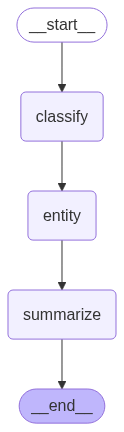

In [103]:
from IPython.display import display, Image
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


## Testing pipeline

In [104]:

text = "Technology and innovation have become the cornerstone of modern progress, revolutionizing every aspect of our daily lives—from communication and healthcare to transportation and education. The rapid advancement of artificial intelligence, robotics, and data science is not only transforming industries but also redefining how people interact with the world. With innovation driving efficiency, accessibility, and sustainability, businesses and governments alike are investing heavily in digital transformation to stay competitive. As technology continues to evolve, it presents both immense opportunities and complex challenges that require thoughtful integration, ethical responsibility, and a future-focused mindset."
state_input = {"text": text}
result = app.invoke(state_input)

print("classification:", result['classification'])
print("entities:", result['entities'])
print("summary:", result['summary'])


Classification Node - Sending Message to LLM:
content='classify the following text into one of the categories: News, Blog, Research \n\nTechnology and innovation have become the cornerstone of modern progress, revolutionizing every aspect of our daily lives—from communication and healthcare to transportation and education. The rapid advancement of artificial intelligence, robotics, and data science is not only transforming industries but also redefining how people interact with the world. With innovation driving efficiency, accessibility, and sustainability, businesses and governments alike are investing heavily in digital transformation to stay competitive. As technology continues to evolve, it presents both immense opportunities and complex challenges that require thoughtful integration, ethical responsibility, and a future-focused mindset.' additional_kwargs={} response_metadata={}
Raw Classification Output: I would classify this text as "Blog". The text is written in a general and 